# 数据挖掘 - 模型评估

## 分类模型评估

### 二分类
- 样本-预测
    - 测试集：Y_test = [0,1,0,0,...,0,1]
    - 处理后的预测结果：Y_pred = [0,1,1,0,...,0,1]
    - 实际预测为一个概率：Y_pred = [0.1,0.8,0.6,0.2,...,0.2,0.9]
- 混淆矩阵
    - TP(True Positive): 实际为正类，预测为正类
    - FN(False Negative): 实际为正类，预测为负类（漏）
    - FP(False Positive): 实际为负类，预测为正类（错）
    - TN(True Negative): 实际为负类，预测为负类
    
<img style="float: center;" src=".\figures\混淆矩阵.png" width=70%>
<center>Fig. 混淆矩阵</center>


- 关键指标
    - **正确率**（Accuracy Rate）：$$\frac{TP+TN}{TP+TN+FN+FP}$$
    - **召回率**（TPR, True Positive Rate/Recall）：$$\frac{TP}{TP+FN}$$
    - **F-measure**（F-score）：$$\frac{2*Recall*Accuracy}{Recall+Accuracy}$$
    - 查准率/精准率（Precision）：$$\frac{TP}{TP+FP}$$
    - 错误接收率（FPR, False Positive Rate）：$$\frac{FP}{FP+TN}$$
    - 错误拒绝率（FRR, False Rejection Rate）：$$\frac{FN}{TP+FN}$$


### 多分类
- 多元混淆矩阵

<img style="float: center;" src=".\figures\多元混淆矩阵.png" width=35%>
<center>Fig. 多元混淆矩阵</center>

- 准确率：保持
- 召回率与 F 值：
    1. 先计算所有的 $TP, FN$ 等，再以二值方法计算
    2. 分别把每个类当作正类，都计算一个召回率或者 F 值，然后取加权或者不加权平均
    

### ROC 与 AUC
- ROC: Receiver Operating characteristic Curve
    - ROC 曲线可以很容易的看到任意界限值对性能识别的影响力
- AUC: Area Under Curve

<img style="float: center;" src=".\figures\roc-auc.png" width=80%>
<center>Fig. ROC 与 AUC</center>


In [15]:
## 导包
import numpy as np # 数值计算
import pandas as pd # 数据分析

In [16]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler # 归一化、标准化
from sklearn.preprocessing import LabelEncoder,OneHotEncoder # 标签化、独热编码
from sklearn.preprocessing import Normalizer # 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA 降维
from sklearn.decomposition import PCA # PCA 降维

In [17]:
## 
# @arg
# sl: statisfaction_level --- Flase: MinMaxScaler; True: StandardScaler
# le: last_evaluation --- Flase: MinMaxScaler; True: StandardScaler
# npr: number_project --- Flase: MinMaxScaler; True: StandardScaler
# amh: average_monthly_hours --- Flase: MinMaxScaler; True: StandardScaler
# tsc: time_spend_company --- Flase: MinMaxScaler; True: StandardScaler
# wa: Work_accident --- Flase: MinMaxScaler; True: StandardScaler
# pl5: promotion_last_5years --- Flase: MinMaxScaler; True: StandardScaler
# dp: Department --- False: LabelEncoding; True: OneHotEncoding
# slr: salary --- False: LabelEncoding; True: OneHotEncoding
# lower_d: 是否降维 --- Default: False
# ld_n: 保留的维数 --- Default: 1
def hr_preprocessing(sl=False, le=False, npr=False, amh=False, tsc=False, wa=False, pl5=False, dp=False, slr=False, lower_d=False, ld_n=1):
    ## 0. 加载数据
    df = pd.read_csv(".//datasets//HR_comma_sep.csv")
    
    ## 1. 清洗数据（去除异常值、抽样，这里数据量较小不进行抽样了）
    df = df.dropna(subset=["satisfaction_level","last_evaluation"])
    df = df[df["satisfaction_level"]<=1][df["salary"]!="nme"]
    
    ## 2. 得到标注
    label = df["left"]
    df = df.drop("left", axis=1)
    
    ## 3. 特征选择
    
    
    ## 4. 特征处理
    # 对 "satisfaction_level", "last_evaluation", "number_project",
    # "average_monthly_hours", "time_spend_company", "Work_accident",
    # "promotion_last_5years" 进行归一化和标准化
    scaler_lst = [sl, le, npr, amh, tsc, wa, pl5]
    column_lst = ["satisfaction_level", "last_evaluation", "number_project", 
                  "average_monthly_hours", "time_spend_company", "Work_accident", 
                  "promotion_last_5years"]
    for i in range(len(scaler_lst)):
        if not scaler_lst[i]:
            df[column_lst[i]] =\
            MinMaxScaler().fit_transform(df[column_lst[i]].values.reshape(-1,1)).reshape(1,-1)[0]
        else:
            df[column_lst[i]] =\
            StandardScaler().fit_transform(df[column_lst[i]].values.reshape(-1,1)).reshape(1,-1)[0]
    # 对 "Department", "salary" 进行标签化和归一化
    scaler_lst = [dp, slr]
    column_lst = ["Department", "salary"]
    for i in range(len(scaler_lst)):
        if not scaler_lst[i]:
            if column_lst[i] == "salary":
                df[column_lst[i]] = [map_salary(s) for s in df["salary"].values]
            else:
                df[column_lst[i]] = LabelEncoder().fit_transform(df[column_lst[i]])
            df[column_lst[i]] = MinMaxScaler().fit_transform(df[column_lst[i]].values.reshape(-1,1)).reshape(1,-1)[0]
        else:
            df = pd.get_dummies(df, columns=[column_lst[i]])
    # 降维
    if lower_d:
        return PCA(n_components=ld_n).fit_transform(df.values),label
#         return LinearDiscriminantAnalysis(n_components=ld_n)
    
    return df,label



In [18]:
##
d = dict([("low",0), ("medium",1), ("high",2)])
def map_salary(s):
    return d.get(s,0)


In [21]:
# %load ".\\code\\load_hr_modeling.py"
## 建模分析
def hr_modeling(features, label):
    from sklearn.model_selection import train_test_split
    f_v = features.values # 特征值
    f_names = features.columns.values # 特征名
    l_v = label.values # 标注
    # 测试集：X_tt, Y_tt
    # 验证集：X_validation, Y_validation
    X_tt,X_validation,Y_tt,Y_validation = train_test_split(f_v, l_v, test_size=0.2)
    X_train,X_test,Y_train,Y_test = train_test_split(X_tt, Y_tt, test_size=0.25)
    print(len(X_train), len(X_validation), len(X_test))
    
    ## 模型构建
    from sklearn.metrics import accuracy_score,recall_score,f1_score # 模型评价
    from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier # KNN
    from sklearn.naive_bayes import GaussianNB,BernoulliNB # 高斯朴素贝叶斯、伯努利朴素贝叶斯
    from sklearn.tree import DecisionTreeClassifier # 决策树
    from sklearn.svm import SVC # 支持向量机
    from sklearn.ensemble import RandomForestClassifier # 随机森林
    from sklearn.ensemble import AdaBoostClassifier # AdaBoost
    from sklearn.linear_model import LogisticRegression # Logistic 回归
    from keras.models import Sequential # 序贯模型
    from keras.layers.core import Dense,Activation # 稠密层、激活函数
    from tensorflow.keras.optimizers import SGD # 随机梯度下降
    f = open(".\\output\\NNLog2.log", 'a') # 自动文件指针打开待写入文件
    mdl = Sequential()
    mdl.add(Dense(50, input_dim=len(f_v[0]))) # 输入层：指定隐含层神经元个数为 50
    mdl.add(Activation("sigmoid")) # 激活函数
    mdl.add(Dense(2)) # 输出层
    mdl.add(Activation("softmax")) # 归一化
    sgd = SGD(lr=0.05) # 学习率
    mdl.compile(loss="mean_squared_error", optimizer="adam") # 编译: 损失函数-均方误差、优化器-亚当优化器
    history = mdl.fit(X_train, np.array([[0,1] if i == 1 else [1,0] for i in Y_train]), epochs=10000, batch_size=8999, verbose=0)
    print("History:", dir(history), file=f) #
    loss_val = history.history
    print("Loss Function:", loss_val, file=f) # 损失和评估值
    f.close() # 关闭文件
    xy_lst = [(X_train,Y_train), (X_validation,Y_validation), (X_test,Y_test)]
    import matplotlib.pyplot as plt # 数据可视化
    from sklearn.metrics import roc_curve,auc,roc_auc_score # ROC、AUC 评价曲线
    f = plt.figure()
    set_name = ["Train:", "Validation:", "Test:"]
    for i in range(len(xy_lst)):
        X_part = xy_lst[i][0]
        Y_part = xy_lst[i][1]
        Y_pred = mdl.predict(X_part)
        print(Y_pred)
        Y_pred = np.array(Y_pred[:,1]).reshape((1,-1))[0]
        print(i, set_name[i])
#         print("NN", "- ACC:", accuracy_score(Y_part, Y_pred))
#         print("NN", "- REC:", recall_score(Y_part, Y_pred))
#         print("NN", "- F1:", f1_score(Y_part, Y_pred))
        f.add_subplot(1,3,i+1)
        fpr,tpr,threshold = roc_curve(Y_part, Y_pred)
        plt.plot(fpr, tpr)
        print("NN", "AUC", auc(fpr, tpr))
        print("NN", "AUC_Score", roc_auc_score(Y_part, Y_pred))
    plt.show()
    # 绘制损失函数曲线
    plt.figure()
    plt.plot(loss_val['loss'])
    plt.title("Loss Function")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Value")
    return 
    
    models = [] # 初始化存放模型的元组
    
#     models.append(("KNN", KNeighborsClassifier(n_neighbors=3))) # KNN
#     models.append(("GaussianNB", GaussianNB())) # Gaussian Naive Bayes
#     models.append(("BernoulliNB", BernoulliNB())) # BernoulliNB Naive Bayes
#     models.append(("DecisionTreeGini", DecisionTreeClassifier())) # 决策树：Gini 系数
#     models.append(("DecisionTreeEntropy", DecisionTreeClassifier(criterion="entropy"))) # 决策树：信息熵
#     models.append(("SVM Classifier", SVC(C=1000))) # 支持向量机：C 值越大模型越准确，计算时间越长
    models.append(("OriginalRandomForest", RandomForestClassifier())) # 随机森林
#     models.append(("RandomForest", RandomForestClassifier(n_estimators=11, max_features=None))) # 随机森林
#     models.append(("AdaBoost", AdaBoostClassifier())) # AdaBoost
    models.append(("LogisticRegression", LogisticRegression(max_iter=10000))) # Logistic 回归
    for clf_name,clf in models:
        print("++++", clf_name, "++++")
        clf.fit(X_train, Y_train)
        xy_lst = [(X_train,Y_train), (X_validation,Y_validation), (X_test,Y_test)]
        set_name = ["Train:", "Validation:", "Test:"]
        for i in range(len(xy_lst)):
            X_part = xy_lst[i][0]
            Y_part = xy_lst[i][1]
            Y_pred = clf.predict(X_part)
#             print(i)
            print(i, set_name[i])
            print(clf_name, "- ACC:", accuracy_score(Y_part, Y_pred))
            print(clf_name, "- REC:", recall_score(Y_part, Y_pred))
            print(clf_name, "- F1:", f1_score(Y_part, Y_pred))



8999 3000 3000


C:\Users\kisso\.conda\envs\tensorflow_gpu\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


[[9.9999905e-01 9.5208941e-07]
 [1.7219359e-01 8.2780641e-01]
 [9.9999976e-01 2.3489706e-07]
 ...
 [9.9999976e-01 1.8042572e-07]
 [9.9562520e-01 4.3748510e-03]
 [8.9505219e-01 1.0494784e-01]]
0 Train:
NN AUC 0.9606671719662442
NN AUC_Score 0.9606671719662442
[[9.9999666e-01 3.3943068e-06]
 [1.0000000e+00 1.8170937e-08]
 [9.5883352e-01 4.1166477e-02]
 ...
 [8.2812263e-03 9.9171877e-01]
 [9.9999869e-01 1.3047901e-06]
 [1.1499173e-01 8.8500822e-01]]
1 Validation:
NN AUC 0.9542053329083119
NN AUC_Score 0.9542053329083119
[[9.9999940e-01 5.5377353e-07]
 [9.9913067e-01 8.6935004e-04]
 [1.0000000e+00 4.2973516e-10]
 ...
 [1.0000000e+00 2.9888266e-08]
 [1.0000000e+00 4.0144585e-18]
 [1.0000000e+00 5.5809878e-08]]
2 Test:
NN AUC 0.9631139965805646
NN AUC_Score 0.9631139965805646


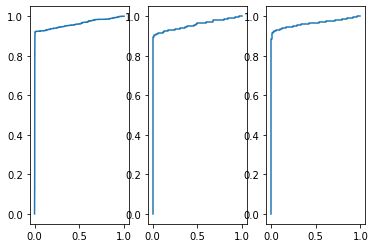

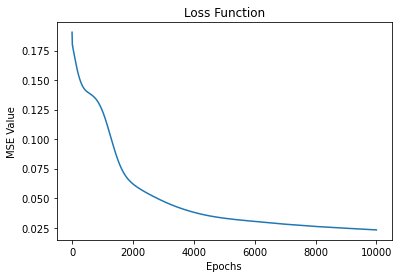

In [22]:
## 
def main():
#     print(hr_preprocessing(sl=True, le=True, lower_d=False, ld_n=3))
    features,label = hr_preprocessing()
    hr_modeling(features, label)
    
if __name__ == "__main__":
    main()
    
    

### 增益图与 KS 图

<img style="float: center;" src=".\figures\增益图与KS图.png" width=50%>
<center>Fig. 增益图与 KS 图</center>



## 回归模型评估
- 关键指标
    - 平均绝对误差（**MAE**, Mean Absolute Error）：$$MAE = \frac{1}{n}\sum^n_{i=1}|f_i-y_i|=\frac{1}{n}\sum^n_{i=1}|e_i|$$
    - 残差平方和（**MSE**, Mean Square Error）：$$MSE = \frac{1}{n}\sum^n_{i=1}(f_i-y_i)^2=\frac{1}{n}\sum^n_{i=1}(e_i)^2$$
    - 均方根误差（**RMSE**, Root MSE）：$$RMSE = \sqrt{MSE}$$
    - 决定系数（**r2_score**）：$$R^2 = \frac{SSR}{SST} = \frac{\sum^n_{i=1}(\hat{y}_i-\bar{y})^2}{\sum^n_{i=1}(y_i-\bar{y})^2}$$


In [12]:
## 回归
def regr_test(features, label):
    print("X", features)
    print("Y", label)
    from sklearn.linear_model import LinearRegression,Ridge,Lasso # 线性回归、岭回归、Lasso 回归
#     regr = LinearRegression() # 线性回归
    regr = Ridge(alpha=0.8) # 岭回归
#     regr = Lasso(alpha=0.002) # Lasso 回归
    regr.fit(features.values, label.values)
    Y_pred = regr.predict(features.values)
    print("Coef", regr.coef_)
    # 模型评价
    from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score # 评价指标：MSE、MAE、R2
    print("MSE:", mean_squared_error(label.values, Y_pred)) # 打印均方误差
    print("MAE:", mean_absolute_error(label.values, Y_pred)) # 打印平均绝对误差
    print("R2:", r2_score(label.values, Y_pred)) # 打印决定系数


In [13]:
# %load ".\\code\\load_main.py"
## main
def main():
    features,label = hr_preprocessing()
    regr_test(features[["number_project","average_monthly_hours"]], features["last_evaluation"])
#     hr_modeling(features, label)
    
if __name__ == "__main__":
    main()
    


X        number_project  average_monthly_hours
0                 0.0               0.285047
1                 0.6               0.775701
2                 1.0               0.822430
3                 0.6               0.593458
4                 0.0               0.294393
...               ...                    ...
14994             0.0               0.257009
14995             0.0               0.299065
14996             0.0               0.219626
14997             0.8               0.859813
14998             0.0               0.289720

[14999 rows x 2 columns]
Y 0        0.265625
1        0.781250
2        0.812500
3        0.796875
4        0.250000
           ...   
14994    0.328125
14995    0.187500
14996    0.265625
14997    0.937500
14998    0.250000
Name: last_evaluation, Length: 14999, dtype: float64
Coef [0.27251659 0.26898178]
MSE: 0.05953801161410218
MAE: 0.2043526214030418
R2: 0.16759928987894634


## 聚类模型评估
- 关键指标
    - 均方根（**RMS**, Root Mean Square）：$$RMS = \frac{1}{n}\sqrt{\sum^n_{i=1}(x_i-\bar{x})^2}$$
    - **轮廓系数**：$a(i)$ 为样本 $i$ 与簇内其他样本的平均距离；$b(i)$ 为样本 $i$ 与其他某簇样本的平均距离，多个簇 $b(i)$ 取最小$$s(i) = \frac{b(i)-a(i)}{max\{a(i),b(i)\}}$$


In [14]:
## 导包
import numpy as np # 数值计算
import matplotlib.pyplot as plt # 绘图

In [15]:
from sklearn.datasets import make_circles,make_blobs,make_moons # 引用数据集
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering # K-means、DBSCAN、层次聚类

Kmeans 0 0.389855717675993
Kmeans 1 0.42833062988234666
Kmeans 2 0.8260921886020176
Kmeans 3 0.39304291583237216
DBSCAN 0 0.11334994640979625
DBSCAN 1 0.33264082008537676
DBSCAN 2 0.8260921886020176
Agglomerative 0 0.3624382024078824
Agglomerative 1 0.4191508445873224
Agglomerative 2 0.8260921886020176
Agglomerative 3 0.3527595430255033


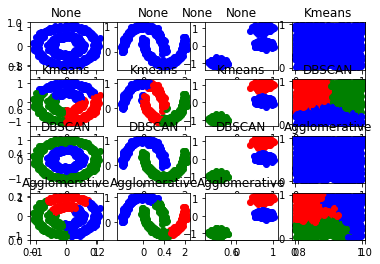

In [17]:
n_samples = 1000 # 样本数
circles = make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
moons = make_moons(n_samples=n_samples, noise=0.05)
blobs = make_blobs(n_samples=n_samples, random_state=8, center_box=(-1,1), cluster_std=0.1)
random_data = np.random.rand(n_samples, 2), None
colors = "bgrcmyk" # 绘图色系
data = [circles,moons,blobs,random_data]
models = [("None", None), 
          ("Kmeans", KMeans(n_clusters=3)), 
          ("DBSCAN", DBSCAN(min_samples=3, eps=0.2)), 
          ("Agglomerative", AgglomerativeClustering(n_clusters=3, linkage="ward"))]
from sklearn.metrics import silhouette_score # 轮廓系数
f = plt.figure()
for inx,clt in enumerate(models):
    clt_name,clt_entity = clt
    for i,dataset in enumerate(data):
        X,Y = dataset
        if not clt_entity:
            clt_res = [0 for item in range(len(X))]
        else:
            clt_entity.fit(X)
            clt_res = clt_entity.labels_.astype(np.int)
        plt.title(clt_name)
        try:
            print(clt_name, i, silhouette_score(X, clt_res))
        except:
            pass
        f.add_subplot(len(models), len(data), inx*len(data)+i+1)
        [plt.scatter(X[p,0], X[p,1], color=colors[clt_res[p]]) for p in range(len(X))]
plt.show()

## 关联模型评估
- 关键指标
    - **支持度（Support）**：项集 $\{ X,Y \}$ 在总项集中出现的概率
    - **置信度（Condfidence）**：在先决条件 $X$ 发生的条件下，由关联规则 $\{ X\rightarrow Y \}$ 推出 $Y$ 的概率
    - **提升度**：表示含有 $X$ 的条件下同时含有 $Y$ 的概率，与无论是否含 $X$ 只要含 $Y$ 的概率之比$$\frac{Confidence(\{X\}\rightarrow\{Y\}}{Support(\{Y\})})$$

